In [1]:
import pandas as pd
from io import BytesIO
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objs as go

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [3]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
init_notebook_mode(connected=True)

#### 1) [1 балл] Первое и, пожалуй, самое сложное, что предстоит сделать, – это найти данные и определиться с тематикой мини-исследования.

In [5]:
url = 'https://docs.google.com/spreadsheets/d/1Ki5s_WhvCEchBdBhFzCoHNohyBGvxU7-XwdP1de0BOE/edit#gid=181658807'

In [6]:
csv_export_url = url.replace('/edit#gid=', '/export?format=csv&gid=') 

In [7]:
csv_export_url

'https://docs.google.com/spreadsheets/d/1Ki5s_WhvCEchBdBhFzCoHNohyBGvxU7-XwdP1de0BOE/export?format=csv&gid=181658807'

In [8]:
data = pd.read_csv(csv_export_url,
                   # Set first column as rownames in data frame
                   index_col=0,
                   # Parse column values
                   parse_dates=['PlayerName'])

In [9]:
data.head()

,Affiliation,League,Birth Date,Age,Height (meters),Position,Foot,nationality,Games Played,Market Value (Euros),Highest Market Value (Euros)
PlayerName,,,,,,,,,,,
Anthony Modeste,1. FC Koln,Bundesliga,4/14/1988,31,31778.0,Forward,right,France,1.0,7000000.0,20000000.0
Benno Schmitz,1. FC Koln,Bundesliga,11/17/1994,25,29952.0,Defender,right,Germany,0.0,1000000.0,1750000.0
Birger Verstraete,1. FC Koln,Bundesliga,4/16/1994,25,27395.0,Midfielder,right,Belgium,0.0,4000000.0,4000000.0
Brady Scott,1. FC Koln,Bundesliga,6/30/1999,20,31778.0,Goalkeeper,right,United States,14.0,100000.0,100000.0
Christian Clemens,1. FC Koln,Bundesliga,4/8/1991,28,28856.0,Midfielder,right,Germany,15.0,1750000.0,3500000.0


Выведем размер данных

In [10]:
print data.shape

(4308, 11)


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [11]:
numeric_cols = ['Age', 'Height (meters)', 'Games Played', 
                'Highest Market Value (Euros)']
categorical_cols = list(set(data.columns.values.tolist()) - set(numeric_cols))

In [12]:
data.columns

Index([u'Affiliation', u'League', u'Birth Date', u'Age', u'Height (meters)',
       u'Position', u'Foot', u'nationality', u'Games Played',
       u'Market Value (Euros)', u'Highest Market Value (Euros)'],
      dtype='object')

In [13]:
X = data.drop('Market Value (Euros)', 1)
y = data['Market Value (Euros)']

#### 2)	[4 балла] После этого вам необходимо сделать разведочный анализ данных (exploratory data analysis, EDA)

#####  a)	[1 балл] Сначала проверить, есть ли пропуски и выбросы в данных. 
    i)	Если данных достаточно много, то пропуски и выбросы можно удалить. 
    ii)	Если их недостаточно много, то нужно добавить бинарный столбец из 0 и 1, где будет отмечено, что не так с  переменной, и создать новую, где проблемные значения переменной будут заменены на среднее или на медиану. 
    iii)	В ходе разведочного анализ данных крайне желательно построить гистограммы распределения и/или ящики с усами и проанализировать их.


Получим число ячеек без данных по кажому столбцу

In [14]:
data.isnull().sum()

Affiliation                       0
League                            0
Birth Date                        0
Age                               0
Height (meters)                  83
Position                         68
Foot                            210
nationality                      86
Games Played                     86
Market Value (Euros)            105
Highest Market Value (Euros)    300
dtype: int64

Ячеек без данных мало относительно общего числа, так что принято решение удалить пустые ячейки

In [15]:
data.dropna(inplace=True)
print data.shape

(3855, 11)


In [16]:
data.isnull().sum()

Affiliation                     0
League                          0
Birth Date                      0
Age                             0
Height (meters)                 0
Position                        0
Foot                            0
nationality                     0
Games Played                    0
Market Value (Euros)            0
Highest Market Value (Euros)    0
dtype: int64

Построим картинку парных зависимостей цифровых признаков друг от друга, с гистограммами признака по диагонали

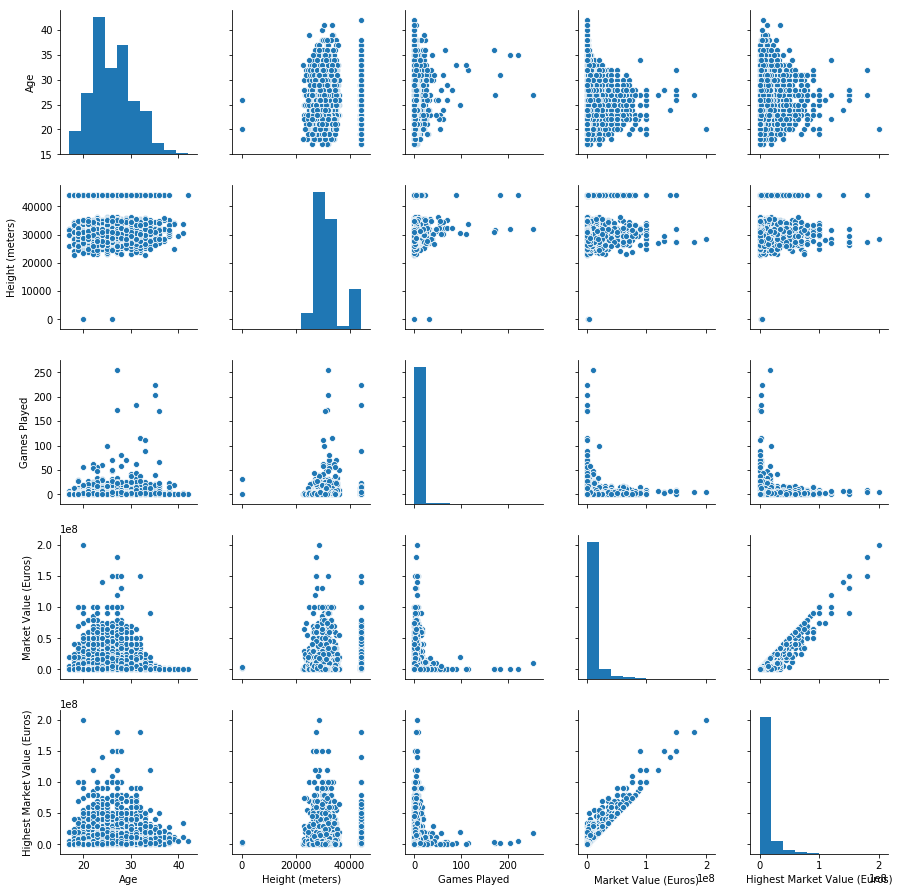

In [17]:
sns.pairplot(data)

Построем гистограмму для целевого показателя 'Market Value (Euros)', ограничев отображение на max 30 млн. евро, ввиду тяжелого левого хвоста гистрограммы

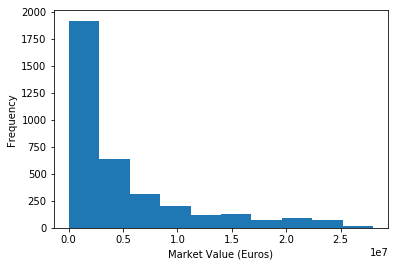

In [18]:
plt.xlabel('Market Value (Euros)')
plt.ylabel('Количество футболистов, шт.')
df = data['Market Value (Euros)']
df[df<30000000].plot.hist()

In [19]:
data.Position.unique().tolist()

['Forward',
 'Defender',
 'Midfielder',
 'Goalkeeper',
 'Position: Goalkeeper',
 'Position: Left',
 'Position: Centre',
 'Position: Left Winger',
 'Position: Attacking Midfield',
 'Position: Central Midfield',
 'Position: Second Striker',
 'Position: Right',
 'Position: Right Winger',
 'Position: Defensive Midfield']

Объединим 'Goalkeeper' с 'Position: Goalkeeper'

In [22]:
data.replace('Goalkeeper',  'Position: Goalkeeper', inplace=True)

In [23]:
x = []
drop_menus = []
list_i = data.Position.unique().tolist()
fig = go.Figure()

for i in list_i:
    data_x = data[data.Position == i]
    fig.add_trace(
       go.Box(y = data_x['Age'].values.tolist(), name = 'Age')
       )

for i in range(len(list_i)):
    v_m = [False]*len(list_i)
    v_m[i] = True
    drop_menus.append(dict(label=list_i[i], method='update', args = [{"visible": v_m},{"title": i} ]))

    
fig.layout.update(title='Age',
   updatemenus = [
      go.layout.Updatemenu(
         direction = "down", yanchor = 'top', active = 0, x = -0.1, y = 1,
         buttons = drop_menus
      )
   ]
)
iplot(fig)

In [24]:
x = []
drop_menus = []
list_i = data.Position.unique().tolist()
fig = go.Figure()

for i in list_i:
    data_x = data[data.Position == i]
    fig.add_trace(
       go.Box(y = data_x['Height (meters)'].values.tolist(), name = 'Height (meters)')
       )

for i in range(len(list_i)):
    v_m = [False]*len(list_i)
    v_m[i] = True
    drop_menus.append(dict(label=list_i[i], method='update', args = [{"visible": v_m},{"title": i} ]))

    
fig.layout.update(title='Height (meters)',
   updatemenus = [
      go.layout.Updatemenu(
         direction = "down", yanchor = 'top', active = 0, x = -0.1, y = 1,
         buttons = drop_menus
      )
   ]
)
iplot(fig)

In [25]:
x = []
drop_menus = []
list_i = data.Position.unique().tolist()
fig = go.Figure()

for i in list_i:
    data_x = data[data.Position == i]
    fig.add_trace(
       go.Box(y = data_x['Games Played'].values.tolist(), name = 'Games Played')
       )

for i in range(len(list_i)):
    v_m = [False]*len(list_i)
    v_m[i] = True
    drop_menus.append(dict(label=list_i[i], method='update', args = [{"visible": v_m},{"title": i} ]))

    
fig.layout.update(title='Games Played',
   updatemenus = [
      go.layout.Updatemenu(
         direction = "down", yanchor = 'top', active = 0, x = -0.1, y = 1,
         buttons = drop_menus
      )
   ]
)
iplot(fig)

In [26]:
x = []
drop_menus = []
list_i = data.Position.unique().tolist()
fig = go.Figure()

for i in list_i:
    data_x = data[data.Position == i]
    fig.add_trace(
       go.Box(y = data_x['Market Value (Euros)'].values.tolist(), name = 'Market Value (Euros)')
       )

for i in range(len(list_i)):
    v_m = [False]*len(list_i)
    v_m[i] = True
    drop_menus.append(dict(label=list_i[i], method='update', args = [{"visible": v_m},{"title": i} ]))

    
fig.layout.update(title='Market Value (Euros)',
   updatemenus = [
      go.layout.Updatemenu(
         direction = "down", yanchor = 'top', active = 0, x = -0.1, y = 1,
         buttons = drop_menus
      )
   ]
)
iplot(fig)

In [27]:
x = []
drop_menus = []
list_i = data.Position.unique().tolist()
fig = go.Figure()

for i in list_i:
    data_x = data[data.Position == i]
    fig.add_trace(
       go.Box(y = data_x['Highest Market Value (Euros)'].values.tolist(), name = 'Highest Market Value (Euros)')
       )

for i in range(len(list_i)):
    v_m = [False]*len(list_i)
    v_m[i] = True
    drop_menus.append(dict(label=list_i[i], method='update', args = [{"visible": v_m},{"title": i} ]))

    
fig.layout.update(title='Highest Market Value (Euros)',
   updatemenus = [
      go.layout.Updatemenu(
         direction = "down", yanchor = 'top', active = 0, x = -0.1, y = 1,
         buttons = drop_menus
      )
   ]
)
iplot(fig)

##### b)	[1 балл] Если в вашем датасете есть категориальные переменные, то их нужно преобразовать в числовые. 

In [28]:
cat_f = ['League','Position', 'Foot', 'nationality']

Добавим преобразованные категориальные признаки в конец таблицы

In [29]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
for n in cat_f:
    data[n+'_num'] = lb_make.fit_transform(data[n])

In [30]:
data

,Affiliation,League,Birth Date,Age,Height (meters),Position,Foot,nationality,Games Played,Market Value (Euros),Highest Market Value (Euros),League_num,Position_num,Foot_num,nationality_num
PlayerName,,,,,,,,,,,,,,,
Anthony Modeste,1. FC Koln,Bundesliga,4/14/1988,31,31778.0,Forward,right,France,1.0,7000000.0,20000000.0,0,1,3,43
Benno Schmitz,1. FC Koln,Bundesliga,11/17/1994,25,29952.0,Defender,right,Germany,0.0,1000000.0,1750000.0,0,0,3,47
Birger Verstraete,1. FC Koln,Bundesliga,4/16/1994,25,27395.0,Midfielder,right,Belgium,0.0,4000000.0,4000000.0,0,2,3,9
Brady Scott,1. FC Koln,Bundesliga,6/30/1999,20,31778.0,Position: Goalkeeper,right,United States,14.0,100000.0,100000.0,0,7,3,108
Christian Clemens,1. FC Koln,Bundesliga,4/8/1991,28,28856.0,Midfielder,right,Germany,15.0,1750000.0,3500000.0,0,2,3,47
Dominick Drexler,1. FC Koln,Bundesliga,5/26/1990,29,29952.0,Midfielder,right,Germany,1.0,4000000.0,4000000.0,0,2,3,47
Ellyes Skhiri,1. FC Koln,Bundesliga,10/5/1995,24,31048.0,Midfielder,right,Tunisia,1.0,12000000.0,12000000.0,0,2,3,105
Florian Kainz,1. FC Koln,Bundesliga,10/24/1992,27,27395.0,Forward,right,Austria,0.0,3000000.0,4500000.0,0,1,3,6
Ismail Jakobs,1. FC Koln,Bundesliga,8/17/1999,20,30682.0,Defender,both,Germany,0.0,100000.0,100000.0,0,0,1,47


#### c)	[0.5 балла] После некоторой подготовки данных можно построить корреляционные таблицы и рассмотреть, насколько переменные взаимосвязаны. Обратите внимание на то, какие независимые переменные наибольшим образом связаны с зависимой.

In [32]:
data.corr()

,Age,Height (meters),Games Played,Market Value (Euros),Highest Market Value (Euros),League_num,Position_num,Foot_num,nationality_num
Age,1.000000,0.033128,0.087628,-0.052070,0.063096,0.107326,0.098844,0.071159,0.001169
Height (meters),0.033128,1.000000,0.039352,-0.025987,-0.025768,0.045664,0.104902,0.027152,0.008650
Games Played,0.087628,0.039352,1.000000,-0.004231,0.002111,-0.036738,0.316383,0.032126,-0.007386
Market Value (Euros),-0.052070,-0.025987,-0.004231,1.000000,0.959925,0.079664,-0.068025,-0.018165,-0.067534
Highest Market Value (Euros),0.063096,-0.025768,0.002111,0.959925,1.000000,0.087836,-0.068054,-0.013530,-0.072892
League_num,0.107326,0.045664,-0.036738,0.079664,0.087836,1.000000,-0.015157,0.017639,0.027088
Position_num,0.098844,0.104902,0.316383,-0.068025,-0.068054,-0.015157,1.000000,0.095460,-0.002665
Foot_num,0.071159,0.027152,0.032126,-0.018165,-0.013530,0.017639,0.095460,1.000000,0.028653
nationality_num,0.001169,0.008650,-0.007386,-0.067534,-0.072892,0.027088,-0.002665,0.028653,1.000000


In [33]:
data.mean()

Age                             2.587367e+01
Height (meters)                 3.199297e+04
Games Played                    2.533333e+00
Market Value (Euros)            8.328742e+06
Highest Market Value (Euros)    1.034103e+07
League_num                      4.146044e+00
Position_num                    1.649287e+00
Foot_num                        2.653956e+00
nationality_num                 5.917588e+01
dtype: float64

Построим матрицу коэффициентов корреляции

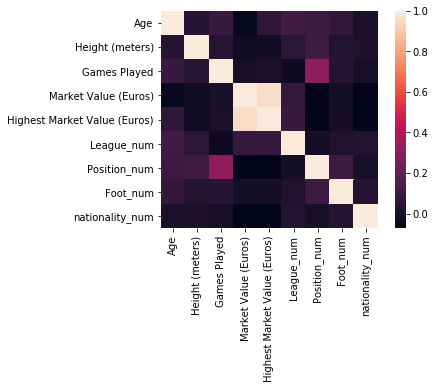

In [34]:
sns.heatmap(data.corr(), square=True)

Построим линейную модель по всем признакам.

In [35]:
['Age', 'Height (meters)', 'Games Played', 
                'Highest Market Value (Euros)']

['Age', 'Height (meters)', 'Games Played', 'Highest Market Value (Euros)']

In [36]:
['League','Position', 'Foot', 'nationality']

['League', 'Position', 'Foot', 'nationality']

In [37]:
data.columns

Index([u'Affiliation', u'League', u'Birth Date', u'Age', u'Height (meters)',
       u'Position', u'Foot', u'nationality', u'Games Played',
       u'Market Value (Euros)', u'Highest Market Value (Euros)', u'League_num',
       u'Position_num', u'Foot_num', u'nationality_num'],
      dtype='object')

In [38]:
data.rename(columns={'Market Value (Euros)':'MarketValueEuros', 'Highest Market Value (Euros)':'HighestMarketValueEuros',
                     'Games Played': 'GamesPlayed', 'Height (meters)': 'Heightmeters'}, inplace=True)

In [39]:
m1 = smf.ols('MarketValueEuros ~ Age + Heightmeters + GamesPlayed + League_num +'\
                    'Position_num + Foot_num + nationality_num', data=data)
fitted = m1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:       MarketValueEuros   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     11.08
Date:                Sun, 17 May 2020   Prob (F-statistic):           6.03e-14
Time:                        22:09:26   Log-Likelihood:                -69209.
No. Observations:                3855   AIC:                         1.384e+05
Df Residuals:                    3847   BIC:                         1.385e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.663e+07   2.36e+06     

C:\Users\oorzhak\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in log



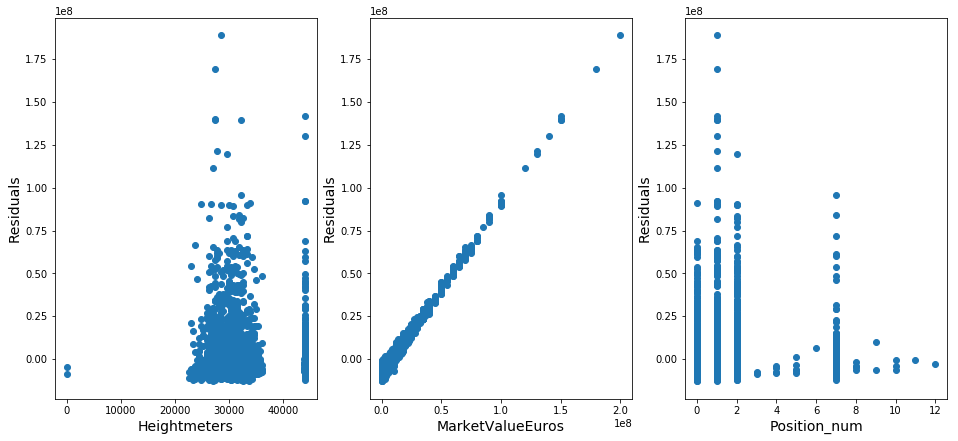

In [40]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)

plt.subplot(131)
scatter(data['Heightmeters'],fitted.resid)
plt.xlabel('Heightmeters', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
scatter(data['MarketValueEuros'],fitted.resid)
plt.xlabel('MarketValueEuros', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
scatter(data['Position_num'],fitted.resid)
plt.xlabel('Position_num', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

### Логарифмируем отклик

                               OLS Regression Results                               
Dep. Variable:     np.log(MarketValueEuros)   R-squared:                       0.055
Model:                                  OLS   Adj. R-squared:                  0.053
Method:                       Least Squares   F-statistic:                     31.99
Date:                      Sun, 17 May 2020   Prob (F-statistic):           1.91e-43
Time:                              22:09:31   Log-Likelihood:                -7093.2
No. Observations:                      3855   AIC:                         1.420e+04
Df Residuals:                          3847   BIC:                         1.425e+04
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

C:\Users\oorzhak\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in log



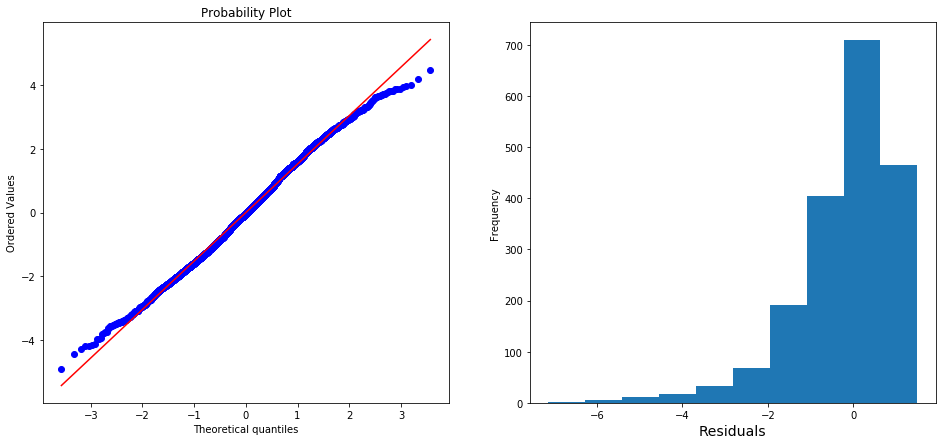

In [41]:
m2 = smf.ols('np.log(MarketValueEuros) ~ Age + Heightmeters + GamesPlayed + League_num +'\
                    'Position_num + Foot_num + nationality_num', data=data)
fitted = m2.fit()
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()